### Analyzing graph of relationships between username and twitter handles used in tweets for both tweets about ISIS and for the ISIS fanboys. Find that the most central Twitter handle for the ISIS fanboys by far is someone called 'Uncle_SamCoco', followed by 'RamiAlLolah', 'WarReporter1','MaghrabiArabi' and 'mobi_ayubi'

### Also looked at topic modeling with 1000 most frequent words in each set using non-negative matrix factorization. Topics for fanboys are more specific (including more references to Uncle_SamCoco and other twitter handles), have more ISIS specific jargon, and focus more on victims.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib
from matplotlib import *
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

AboutIsis.csv
IsisFanboy.csv



In [2]:
about_data = pd.read_csv('../input/AboutIsis.csv',encoding = "ISO-8859-1")
fanboy_data = pd.read_csv('../input/IsisFanboy.csv',encoding = "ISO-8859-1")

In [3]:
about_data.keys()

Index(['name', 'username', 'tweetid', 'time', 'tweets'], dtype='object')

In [4]:
fanboy_space_split = [str(i).split() for i in fanboy_data['tweets']]
fanboy_handles = [j for i in fanboy_space_split for j in i if '@' in j]
about_space_split = [str(i).split() for i in about_data['tweets']]
about_handles = [j for i in about_space_split for j in i if '@' in j]

#### **See that the ratio users to references to other handles is significantly higher for tweets about ISIS than for ISIS fanboys**

In [5]:
print(len(set(fanboy_data['username']))/len(set(fanboy_handles)),
      len(set(about_data['username']))/len(set(about_handles)))

0.02943474863245637 5.385844491954541


In [6]:
import networkx as nx

In [7]:
fanboy_edges = [(k,j[1:]) for k,i in zip(fanboy_data['username'],fanboy_space_split) for j in i if '@' in j]
about_edges = [(k,j[1:]) for k,i in zip(about_data['username'],about_space_split) for j in i if '@' in j]

In [8]:
about_graph = nx.Graph()
fanboy_graph = nx.Graph()

In [9]:
about_graph.add_edges_from(about_edges)
fanboy_graph.add_edges_from(fanboy_edges)

#### **The average degree of nodes for fanboys is slightly higher than for tweets about ISIS**

In [10]:
print(1/(float(fanboy_graph.order())/float(fanboy_graph.size())))
print(1/(float(about_graph.order())/float(about_graph.size())))

1.4916301828483132
1.0530127958231694


In [11]:
fanboy_cc = nx.connected_component_subgraphs(fanboy_graph)
bet_cen = nx.betweenness_centrality([i for i in fanboy_cc][0])

In [12]:
fanboy_cc = nx.connected_component_subgraphs(fanboy_graph)
clo_cen = nx.closeness_centrality([i for i in fanboy_cc][0])

#### **Can look at the Twitter handles that are most connected through tweet references in the graph. See outliers 'Uncle_SamCoco' and 'RamiAlLolah'**

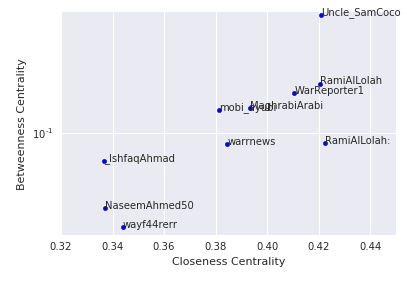

In [13]:
fig, ax = matplotlib.pyplot.subplots()
ax.scatter(list(clo_cen.values()),list(bet_cen.values()))
ax.set_ylim(0.04,0.3)
ax.set_xlim(0.32,0.45)
ax.set_xlabel("Closeness Centrality")
ax.set_ylabel("Betweenness Centrality")
ax.set_yscale('log')
for i, txt in enumerate(list(clo_cen.keys())):
    ax.annotate(txt, (list(clo_cen.values())[i],list(bet_cen.values())[i]))

In [14]:
import re
fanboy_text = [re.sub("[^a-zA-Z]"," ",j).lower() for i in fanboy_space_split for j in i if (not('@' in j) and not('#' in j))]
about_text = [re.sub("[^a-zA-Z]"," ",j).lower() for i in about_space_split for j in i if (not('@' in j) and not('#' in j))]

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
fc_vectorizer = CountVectorizer(stop_words='english',max_features=1000)
fanboy_counts = fc_vectorizer.fit_transform(fanboy_text)
ac_vectorizer = CountVectorizer(stop_words='english',max_features=1000)
about_counts = ac_vectorizer.fit_transform(about_text)

#### **Use non-negative matrix factorization of 1000 most frequent words to determine topics for fanboys and tweets.**

In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [17]:
from sklearn.decomposition import NMF
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20
fanboy_nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(fanboy_counts)

#### **Topics for fanboys are very specific, containing Twitter jargon (Topic 0) and many ISIS specific terms (Topic 5). Have topic of victims of airstrikes (Topic 6), and operations in Iraq (Topic 9)**

In [18]:
fanboy_feature_names = fc_vectorizer.get_feature_names()
print_top_words(fanboy_nmf, fanboy_feature_names, n_top_words)

Topic #0:
status twitter com https photo nidalgazaui sparksofirhabi video uncle samcoco markito layers thatcoffeetho middleeasteye utm afp alarabiya terror nusra source
Topic #1:
rt com news syria follow turkey russia usa brussels saudi fsa aircraft daesh general taking somalia op department putin base
Topic #2:
com twitter account suspended https utm source linkis medium social campaign true content error nytimes online talks mosul refuse thatcoffeetho
Topic #3:
com www facebook unsupportedbrowser youtube watch feature youtu https linkis tw error nytimes story share military refuse articles online usa
Topic #4:
https justpaste org youtube archive watch details news feature youtu en com nytimes wordpress error vid html world ra vice
Topic #5:
al qaeda nusra islam sham baghdadi ansari rai awlaki adnani asad ayn yarmouk iraqi anbar sharia new ta ra html
Topic #6:
killed injured airstrike leader victims people western million civilians british muslims jihadi www police cnn airstrikes poli

In [19]:
about_nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(about_counts)

#### **Topics in articles about ISIS are much more generic (and ofter contain references to newspapers or websites/applications like Topic 2 or Topic 3). More specific topics focus more on the victims of terrorism (Topics 5 and 8) , or terrorism in general (Topic 7)**

In [20]:
about_feature_names = ac_vectorizer.get_feature_names()
print_top_words(about_nmf, about_feature_names, n_top_words)

Topic #0:
isis www utm dailymail org asia com washingtonpost cnn pokemon war article claimed time extremists gives battles game anti double
Topic #1:
rt actualidad com estado islamico futbolistas www international incirlik hulk news usa troops fight iranian russia airbase iraq daesh turkey
Topic #2:
http com www html iraq cnn mosul article index middleeast nytimes utm baghdad en daesh fb politics news asia carter
Topic #3:
com twitter pic status user utm id intent yjsh agm orlfvpz medium source pu campaign news theverge social content photo
Topic #4:
https com status user www washingtonpost id intent wp worst days worldviews alleged story turkey extremists security ce game aa
Topic #5:
muslim lives suicide man hundreds saves explosion wearing vest hugs armed militant indiatimes html news com india world firstpost wordpress
Topic #6:
news world www attack uk html east middle probably cares independent http weeks deadly washingtonpost dailymail worst days wp article
Topic #7:
islamic sta